# Реализовано на Python 3.11

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(42)

In [3]:


class TicTacToeModel(nn.Module):
    def __init__(self):
        super(TicTacToeModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(9, 128),  # Вход: состояние доски 3x3
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 9)  # Выход: оценки для каждого из 9 ходов
        )

    def forward(self, x):
        return self.fc(x)




In [4]:
class NeuralNetwork:
    def __init__(self, breed="neural", gamma=0.9, lr=0.001):
        self.breed = breed
        self.model = TicTacToeModel()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.last_state = None
        self.last_move = None
        self.losses = []
        self.gamma = gamma

    def normalize_board(self, board):
        return [(1 if c == 'X' else -1 if c == 'O' else 0) for c in board]

    def start_game(self):
        self.last_state = None
        self.last_move = None

    def move(self, board):
        normalized_state = self.normalize_board(board)
        state = torch.FloatTensor(normalized_state).unsqueeze(0)
        with torch.no_grad():
            outputs = self.model(state).squeeze(0)
        available_move = [i for i, cell in enumerate(board) if cell == ' ']
        valid_outputs = outputs[available_move]
        move = available_move[valid_outputs.argmax().item()] if random.random() > 0.2 else random.choice(available_move)
        self.last_state = state
        self.last_move = move
        return move + 1

    def reward(self, value, board):
        if self.last_state is not None:
            next_state = self.normalize_board(board)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            with torch.no_grad():
                max_next_q = self.model(next_state).max().item()
            target = self.model(self.last_state.clone()).squeeze(0)
            char = 'X' if self.breed == "neural" else 'O'
            opponent_char = 'O' if char == 'X' else 'X'
            center = [4]
            corners = [0, 2, 6, 8]


            win_conditions = [
                (0, 1, 2), (3, 4, 5), (6, 7, 8),  # Горизонтальные победы
                (0, 3, 6), (1, 4, 7), (2, 5, 8),  # Вертикальные победы
                (0, 4, 8), (2, 4, 6)              # Диагональные победы
            ]


            missed_win = False
            for a, b, c in win_conditions:
                if (
                    [board[a], board[b], board[c]].count(char) == 2 and  # Два символа текущего игрока
                    [board[a], board[b], board[c]].count(' ') == 1 and  # и если есть одна пустая клетка
                    self.last_move not in (a, b, c)  # Модель не завершила игру
                ):
                    missed_win = True
                    # print(f"Упущенная возможность выиграть в комбинации {a, b, c}")
                    value -= 1.0  # Штраф за упущение выигрыша
                    break


            if not missed_win:  # Только если нет условий для победы


                missed_block = False
                for a, b, c in win_conditions:
                    if (
                        [board[a], board[b], board[c]].count(opponent_char) == 2 and  # Два символа противника
                        [board[a], board[b], board[c]].count(' ') == 1 and  # Одна пустая клетка
                        self.last_move not in (a, b, c)  # если не заблокировала
                    ):
                        missed_block = True
                        # print(f"Упущена блокировка потенциального выигрыша противника в комбинации {a, b, c}")
                        value -= 1.0  # Штраф за упущение блокировки
                        break
                if not missed_block:
                    for a, b, c in win_conditions:
                        # Если текущий ход (`self.last_move`) сделал комбинацию потенциально выигрышной
                        if (
                            self.last_move in (a, b, c) and  # Текущий ход был в одной из ячеек комбинации
                            [board[a], board[b], board[c]].count(char) == 2 and  # Два символа текущего игрока
                            [board[a], board[b], board[c]].count(' ') == 1  # и одна пустая клетка
                        ):
                            # print(f"Получена награда {self.last_move} за потенциальный ход-выигрыш в комбинации {a, b, c}")
                            value += 0.8  # Награда за создание потенциального выигрыша
                            break

                    if self.last_move in corners and board[self.last_move] == char:
                        value += 0.2  # Награда за занятие угла
                    elif self.last_move in center and board[self.last_move] == char:
                        value += 0.4  # Награда за занятие центра

            target[self.last_move] = torch.clamp(
                torch.tensor(value + self.gamma * max_next_q, requires_grad=True), -1, 1
            )
            # current_prediction = self.model(self.last_state).squeeze(0)[self.last_move].item()
            # print(f"{self.breed} - Целевое значение для последнего хода {target[self.last_move].item()}")
            # print(f"{self.breed} - Текущее предсказание для последнего хода {current_prediction}")

            self.optimizer.zero_grad()
            loss = self.criterion(self.model(self.last_state).squeeze(0), target)
            loss.backward()
            self.optimizer.step()
            self.game_losses.append(loss.item())
            self.losses.append(loss.item())


In [5]:
def log_model_updates(player, step):
    """
    Логирование изменений модели для отладки.
    :param player: Игрок (NeuralNetworkPlayer)
    :param step: Текущий шаг/ход
    """
    print(f"\n=== Изменения модели {player.breed} на шаге {step} ===")
    print("Первые веса сети (fc[0].weight[0]):", player.model.fc[0].weight[0].detach().numpy())
    print("Текущие потери (losses):", player.losses[-5:] if player.losses else "Нет данных")

In [6]:
class TicTacToe:
    def __init__(self, playerX, playerO, display_interval=100):
        self.board = [' '] * 9
        self.playerX, self.playerO = playerX, playerO
        self.playerX_turn = True
        self.display_interval = display_interval
        self.stats = {
            "X_wins": 0,
            "O_wins": 0,
            "draws": 0,
            "X_rewards": [],
            "O_rewards": [],
            "X_game_losses": [],  # Средние loss за игру
            "O_game_losses": []   # Средние loss за игру
        }

    def display_board(self):
        print('     |     |     ')
        print(f'  {self.board[0]}  |  {self.board[1]}  |  {self.board[2]}  ')
        print('_____|_____|_____')
        print('     |     |     ')
        print(f'  {self.board[3]}  |  {self.board[4]}  |  {self.board[5]}  ')
        print('_____|_____|_____')
        print('     |     |     ')
        print(f'  {self.board[6]}  |  {self.board[7]}  |  {self.board[8]}  ')
        print('     |     |     ')

    def player_wins(self, char):
        for a, b, c in [(0, 1, 2), (3, 4, 5), (6, 7, 8),
                        (0, 3, 6), (1, 4, 7), (2, 5, 8),
                        (0, 4, 8), (2, 4, 6)]:
            if char == self.board[a] == self.board[b] == self.board[c]:
                return True
        return False

    def board_full(self):
        return not any([space == ' ' for space in self.board])

    def play_game(self, train=True, game_number=0):
        self.board = [' '] * 9
        self.playerX.start_game()
        self.playerO.start_game()
        self.playerX.game_losses = []
        self.playerO.game_losses = []
        # Чередование первого игрока
        self.playerX_turn = (game_number % 2 == 0)  # True если первым ходит X, иначе O

        step = 0  # Номер шага
        while True:
            # Определяем текущего игрока
            if self.playerX_turn:
                player, char, other_player = self.playerX, 'X', self.playerO
            else:
                player, char, other_player = self.playerO, 'O', self.playerX

            # Ход игрока
            move = player.move(self.board)
            if move is None or self.board[move - 1] != ' ':
                self.playerX_turn = not self.playerX_turn
                continue

            # Обновляем доску
            self.board[move - 1] = char

            # Проверка на победу
            if self.player_wins(char):
                # print(f"{char} победил!")
                if char == 'X':
                    self.stats["X_wins"] += 1
                else:
                    self.stats["O_wins"] += 1

                player.reward(1, self.board)
                other_player.reward(-1, self.board)
                break

            # Проверка на ничью
            if self.board_full():
                # print("Ничья!")
                self.stats["draws"] += 1
                player.reward(0, self.board)
                other_player.reward(0, self.board)
                break

            # Обновление награды в середине игры
            if train:
                player.reward(0, self.board)

            # Смена хода
            self.playerX_turn = not self.playerX_turn
            step += 1

        if self.playerX.game_losses:
            self.stats["X_game_losses"].append(sum(self.playerX.game_losses) / len(self.playerX.game_losses))
        if self.playerO.game_losses:
            self.stats["O_game_losses"].append(sum(self.playerO.game_losses) / len(self.playerO.game_losses))\

        if char == 'X':
            self.stats["X_rewards"].append(1)
            self.stats["O_rewards"].append(-1)
        elif char == 'O':
            self.stats["X_rewards"].append(-1)
            self.stats["O_rewards"].append(1)
        else:
            self.stats["X_rewards"].append(0)
            self.stats["O_rewards"].append(0)



In [7]:
model_one = NeuralNetwork(breed="model1")
model_two = NeuralNetwork(breed="model2")
model_one.learning_rates = []
model_two.learning_rates = []

In [8]:
game = TicTacToe(model_one, model_two)

In [9]:

# Обучение
for i in range(10000):
    print(f"===Эпизод{i}")
    game.play_game(train=True, game_number=i) #


# Вывод статистики
print("=== Training Results ===")
print(f"Player X wins: {game.stats['X_wins']}")
print(f"Player O wins: {game.stats['O_wins']}")
print(f"Draws: {game.stats['draws']}")




Выходные данные были обрезаны до нескольких последних строк (5000).
===Эпизод5004
===Эпизод5005
===Эпизод5006
===Эпизод5007
===Эпизод5008
===Эпизод5009
===Эпизод5010
===Эпизод5011
===Эпизод5012
===Эпизод5013
===Эпизод5014
===Эпизод5015
===Эпизод5016
===Эпизод5017
===Эпизод5018
===Эпизод5019
===Эпизод5020
===Эпизод5021
===Эпизод5022
===Эпизод5023
===Эпизод5024
===Эпизод5025
===Эпизод5026
===Эпизод5027
===Эпизод5028
===Эпизод5029
===Эпизод5030
===Эпизод5031
===Эпизод5032
===Эпизод5033
===Эпизод5034
===Эпизод5035
===Эпизод5036
===Эпизод5037
===Эпизод5038
===Эпизод5039
===Эпизод5040
===Эпизод5041
===Эпизод5042
===Эпизод5043
===Эпизод5044
===Эпизод5045
===Эпизод5046
===Эпизод5047
===Эпизод5048
===Эпизод5049
===Эпизод5050
===Эпизод5051
===Эпизод5052
===Эпизод5053
===Эпизод5054
===Эпизод5055
===Эпизод5056
===Эпизод5057
===Эпизод5058
===Эпизод5059
===Эпизод5060
===Эпизод5061
===Эпизод5062
===Эпизод5063
===Эпизод5064
===Эпизод5065
===Эпизод5066
===Эпизод5067
===Эпизод5068
===Эпизод5069
===Эпизо

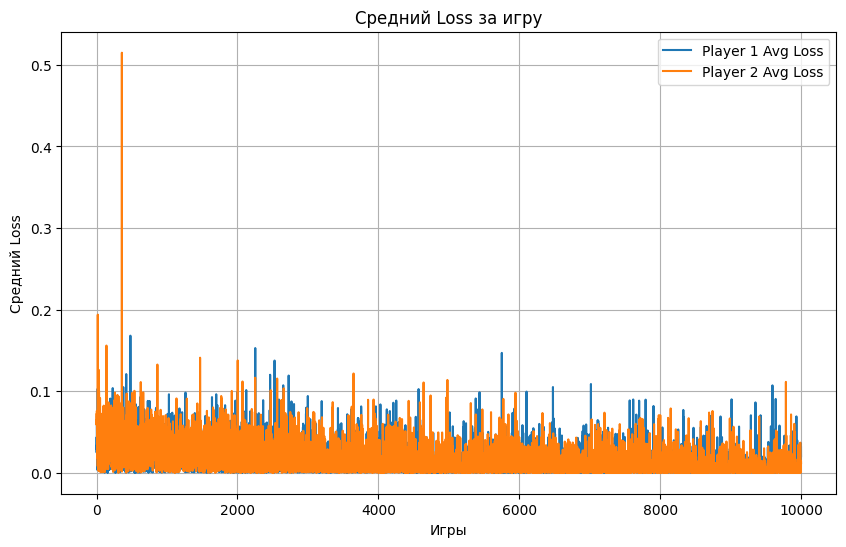

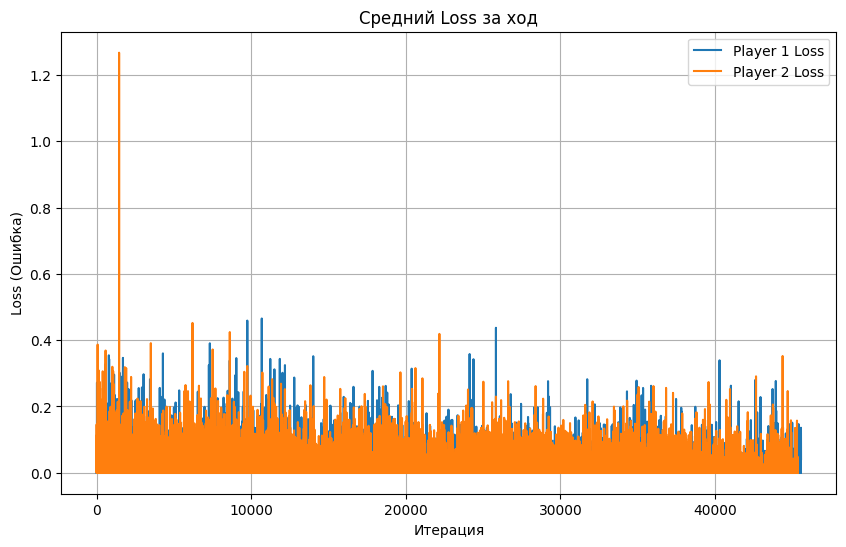

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(game.stats["X_game_losses"], label="Player 1 Avg Loss")
plt.plot(game.stats["O_game_losses"], label="Player 2 Avg Loss")
plt.xlabel("Игры")
plt.ylabel("Средний Loss")
plt.title("Средний Loss за игру")
plt.legend()
plt.grid(True)
plt.show()
# Loss
plt.figure(figsize=(10, 6))
plt.plot(model_one.losses, label="Player 1 Loss")
plt.plot(model_two.losses, label="Player 2 Loss")
plt.xlabel("Итерация")
plt.ylabel("Loss (Ошибка)")
plt.title("Средний Loss за ход")
plt.legend()
plt.grid(True)
plt.show()




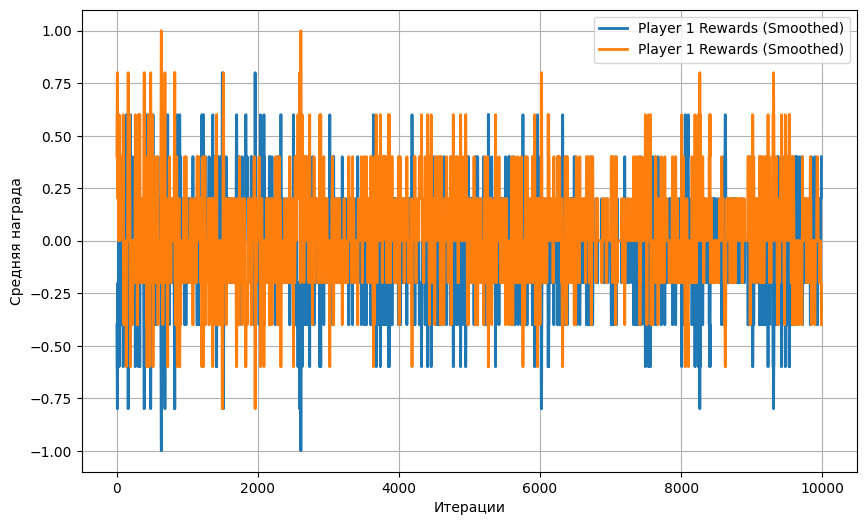

In [24]:
def smooth(data, window_size=10):
    """Применяет скользящее среднее для сглаживания данных"""
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

window_size = 10
smoothed_x_rewards = smooth(game.stats["X_rewards"], window_size)
smoothed_o_rewards = smooth(game.stats["O_rewards"], window_size)
plt.figure(figsize=(10, 6))
plt.plot(smoothed_x_rewards, label="Player 1 Rewards (Smoothed)", linewidth=2)
plt.plot(smoothed_o_rewards, label="Player 1 Rewards (Smoothed)", linewidth=2)
plt.xlabel("Итерации")
plt.ylabel("Средняя награда")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
class TicTacToePlay(TicTacToe):
    def __init__(self, playerX, playerO, display_interval=100):
        super().__init__(playerX, playerO, display_interval)

    def user_move(self, char):
        """
        Запрашивает ход у пользователя и обновляет доску.
        """
        while True:
            try:
                move = int(input(f"\nВаш ход ({char}): Введите число от 1 до 9: ")) - 1
                if move < 0 or move >= 9 or self.board[move] != ' ':
                    print("Некорректный ввод")
                else:
                    return move
            except ValueError:
                print("Некорректный ввод")

    def play_with_user(self, user_char, first_move, ai_model):
        """
        Игра против пользователя.
        - user_char: 'X' или 'O' — за кого вы играете
        - first_move: True, если пользователь хочет ходить первым
        - ai_model: Модель, с которой играет пользователь
        """
        self.board = [' '] * 9
        self.playerX.start_game()
        self.playerO.start_game()


        print(f"Вы играете за {user_char}. AI играет за {'X' if user_char == 'O' else 'O'}.")

        self.playerX_turn = first_move  # Определяем кто ходит первым

        while True:
            if self.playerX_turn:
                char = 'X'
                if user_char == 'X':
                    move = self.user_move(char)
                else:
                    move = ai_model.move(self.board) - 1
            else:
                char = 'O'
                if user_char == 'O':
                    move = self.user_move(char)
                else:
                    move = ai_model.move(self.board) - 1

            self.board[move] = char
            self.display_board()

            # Проверка победы
            if self.player_wins(char):
                print(f"{char} победил!")
                break

            # Проверка ничьей
            if self.board_full():
                print("Ничья!")
                break

            # Смена хода
            self.playerX_turn = not self.playerX_turn

In [18]:
interactive_game = TicTacToePlay(model_one, model_two)

In [14]:
user_char = 'X'

In [19]:
# Выбор первого хода
first_move = input("\nХотите ходить первым? (да/нет): ").strip().lower() in ('да', 'yes', 'y')


Хотите ходить первым? (да/нет): да


In [20]:
# Раскоментить если необходимо выирать модель самому
# # Выбор модели
# model_choice = input("С какой моделью вы хотите играть? model2 или model1").strip().lower()
# while model_choice not in ('model1', 'model2'):
#     model_choice = input("Некорректный ввод ").strip().lower()

chosen_model = model_two if game.stats['O_wins'] > game.stats['X_wins'] else model_one
print(game.stats['O_wins'])
print(game.stats['X_wins'])



2565
2028


In [22]:
interactive_game.play_with_user(user_char, first_move, chosen_model)

Вы играете за X. AI играет за O.

Ваш ход (X): Введите число от 1 до 9: 1
     |     |     
  X  |     |     
_____|_____|_____
     |     |     
     |     |     
_____|_____|_____
     |     |     
     |     |     
     |     |     
     |     |     
  X  |     |  O  
_____|_____|_____
     |     |     
     |     |     
_____|_____|_____
     |     |     
     |     |     
     |     |     

Ваш ход (X): Введите число от 1 до 9: 5
     |     |     
  X  |     |  O  
_____|_____|_____
     |     |     
     |  X  |     
_____|_____|_____
     |     |     
     |     |     
     |     |     
     |     |     
  X  |     |  O  
_____|_____|_____
     |     |     
     |  X  |     
_____|_____|_____
     |     |     
     |     |  O  
     |     |     

Ваш ход (X): Введите число от 1 до 9: 4
     |     |     
  X  |     |  O  
_____|_____|_____
     |     |     
  X  |  X  |     
_____|_____|_____
     |     |     
     |     |  O  
     |     |     
     |     |     
  X  |     |  O 